# Initialization

In [0]:
# Ensuring running on TensorFlow 2.X
%tensorflow_version 2.x

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf

# Check on versioning and gpu usage
print(f"TensorFlow version\t: {tf.__version__}")
print(f"GPU check\t: {tf.test.gpu_device_name()}")

# Check on what GPU we use
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


TensorFlow version	: 2.2.0-rc2
GPU check	: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2548495412051744391, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2593106222890782466
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12028719008235864001
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13708427664879101107
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# Configuring Google Drive directory

In [0]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive            
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Simplify path using symbolic link!
!ln -s "/content/gdrive/My Drive/Projects/bangkit/" /mydrive

# Testing the directory
!ls /mydrive
!pwd

project01-pneumonia_classifier
/content


In [0]:
# Configuring main directory
%cd /mydrive/project01-pneumonia_classifier/main
!ls


bangkit-project01.ipynb


# Importing Modules

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

color = sns.color_palette()
%matplotlib inline
seed_number = 24

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
root = "../input"
print(f"Main directories\t: {os.listdir(root)}")
input_dir = os.path.join(root, "chest-xray-pneumonia", "chest_xray")
print(f"Dataset sub-directories\t: {os.listdir(input_dir)}")
print(f"Train set directory\t: {os.listdir(os.path.join(input_dir, 'train'))}")

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Main directories	: ['xception', 'chest-xray-pneumonia']
Dataset sub-directories	: ['val', 'train', 'test']
Train set directory	: ['NORMAL', 'PNEUMONIA']


In [0]:
# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

In [0]:
# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [0]:
# Set seed nunmber to all packages
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

# Observing the Dataset
Grasping some of the dataset information

In [0]:
# Create train, val and test directories
train_dir = os.path.join(input_dir, 'train')
val_dir = os.path.join(input_dir, 'val')
test_dir = os.path.join(input_dir, 'test')

dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
label_name = os.listdir(os.path.join(input_dir, 'train'))
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(glob.glob(os.path.join(val, label, "*.jpeg")))
        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

           train  val  test
NORMAL      1341    8   234
PNEUMONIA   3875    8   390


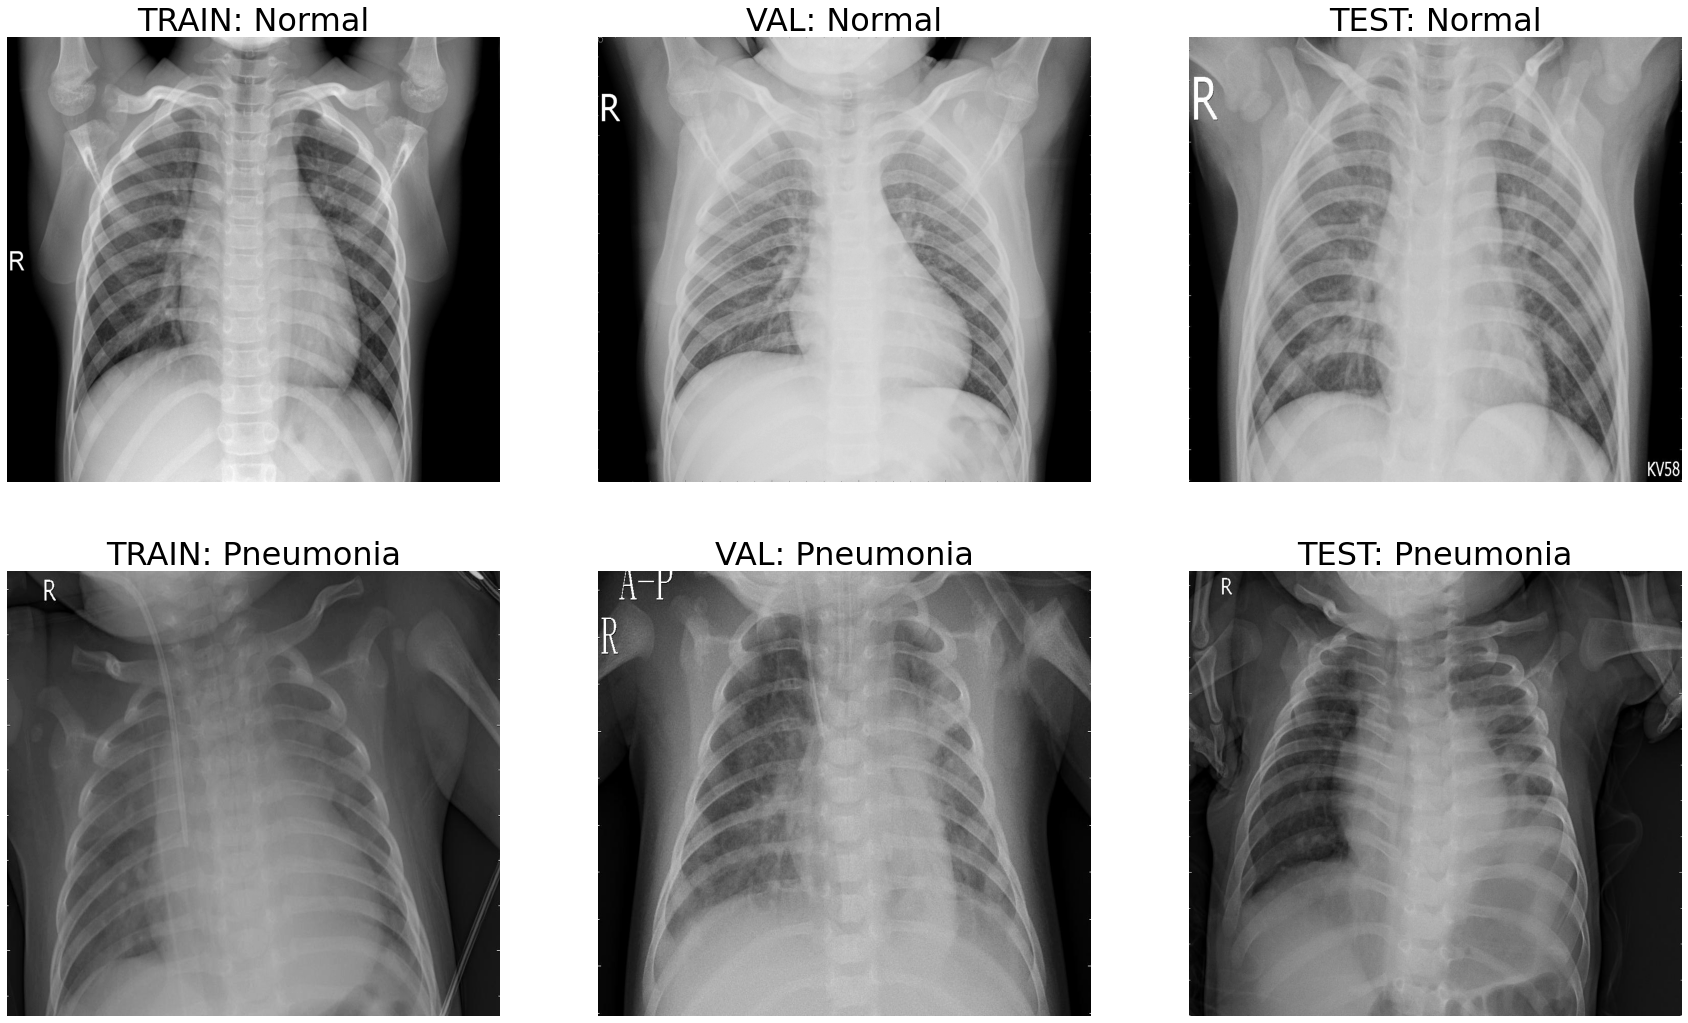

In [0]:
# Visualizing some of the data set
num_classes = len(label_name)
f, ax = plt.subplots(num_classes, 3, figsize=(30, 18))

for k in range(num_classes*3):
    j, i = k//3, k%3  # Image indexing
    
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [0]:
# Instantiate data generator for training procedure
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.05,
                                   shear_range = 0.1,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [0]:
# Define dataset properties
train_batch_size = 32
val_batch_size = 32
img_width = 299
img_height = 299

# Generate dataset for train, val and test
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

test_gen = test_datagen.flow_from_directory(test_dir,
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            target_size = (img_width, img_height),
                                            seed = seed_number,
                                            shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Displaying the dataset generator information
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}')

Train set batch shape	: (32, 299, 299, 3)
Val set batch shape	: (16, 299, 299, 3)
Test set batch shape	: (1, 299, 299, 3)


# Generate Model
Using a pre-trained Xception model, provided by tensorflow

In [0]:
# Don't forget to turn on the Internet to download the respective pre-trained weights!
pretrain_net = xception.Xception(input_shape = (img_width, img_height, 3),
                                    include_top = False,
                                    weights = 'imagenet')

# load_param_path = '../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Offline alternative
# pretrain_net.load_weights(load_param_path)  # Manually load the weights from the input directory

# ------ Freezing layer(s) up to a specific layer ------
freeze_to = 'block4_sepconv1_act'  # use 'None' for training all the layers instead!

if freeze_to:
    for layer in pretrain_net.layers:
        if layer.name == freeze_to:
            break
        else:
            layer.trainable = False


In [0]:
# Adding extra layer for our problem
x = pretrain_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=1024, activation='relu', name='extra_fc1')(x)
x = Dropout(rate=0.3, name='extra_dropout1')(x)
x = Dense(units=512, activation='relu', name='extra_fc2')(x)
x = Dropout(rate=0.3, name='extra_dropout2')(x)
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='xception_pneumonia')
print(model.summary())

Model: "xception_pneumonia"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_________________________________________________________________________________

# Perform Training
Define the training procedure

In [0]:
train_id = "train00"  # ID of the training procedure
num_epochs = 20  # Set the number of epochs to train
learning_rate = 0.0001  # Set the learning rate to use

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])


# Define model callback
save_dir = os.path.join("../output", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "xception-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "xception-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

# Instantiate tensorboard
log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

# Displaying tensorboard
#%tensorboard --logdir log_dir


In [0]:
# Resume training (UNCOMMENT to use!)
# checkpoint_path = "xception-epoch_01"
# model.load(os.path.join(savedir, checkpoint_path))

# Perform training
history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [cont_checkpoint,
                                 best_checkpoint]
                   )

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

Epoch 1/20
163/163 [==============================] - 163s 998ms/step - loss: 0.1279 - acc: 0.9475 - val_loss: 0.0984 - val_acc: 1.0000
Epoch 2/20
163/163 [==============================] - 161s 989ms/step - loss: 0.0506 - acc: 0.9816 - val_loss: 0.1046 - val_acc: 1.0000
Epoch 3/20
163/163 [==============================] - 162s 993ms/step - loss: 0.0332 - acc: 0.9881 - val_loss: 0.2591 - val_acc: 0.8125
Epoch 4/20
163/163 [==============================] - 163s 998ms/step - loss: 0.0276 - acc: 0.9898 - val_loss: 0.0462 - val_acc: 1.0000
Epoch 5/20
163/163 [==============================] - 163s 1s/step - loss: 0.0203 - acc: 0.9933 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 6/20
163/163 [==============================] - 161s 988ms/step - loss: 0.0237 - acc: 0.9921 - val_loss: 0.0441 - val_acc: 1.0000
Epoch 7/20
163/163 [==============================] - 161s 990ms/step - loss: 0.0161 - acc: 0.9948 - val_loss: 0.2501 - val_acc: 0.8750
Epoch 8/20
163/163 [==============================]

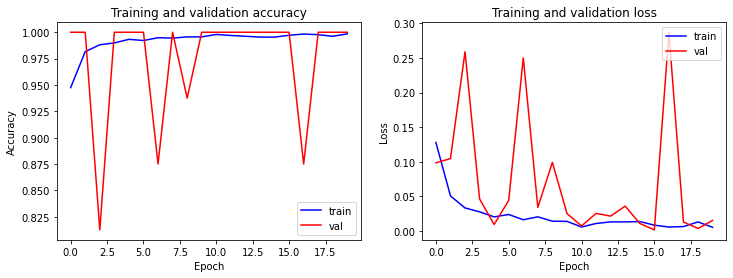

In [0]:
# Plotting the train results
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation
Use this section to evaluate the model performance on the Test set.

In [0]:
# Test set accuracy and loss
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

# Calculate prediction
threshold = 0.5  # Define the sigmoid threshold for True or False
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))
y_pred = np.zeros(y_pred_value.shape)

y_pred[y_pred_value > threshold] = 1
y_true = test_gen.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

624/624 [==============================] - 10s 16ms/step - loss: 0.8356 - acc: 0.8846
Test results Accuracy: 88.46% and Loss: 88.46
624/624 [==============================] - 10s 16ms/step
Label	: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


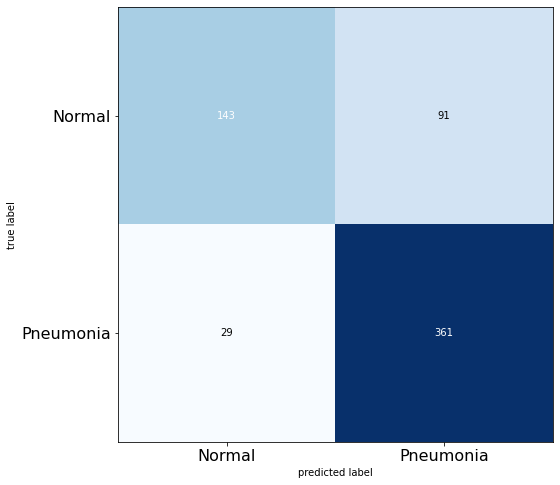

Report Summary:
Precision	: 79.87%
Recall		: 92.56%
F1 Score	: 85.75%


In [0]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)
print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

# Classification report
#print(classification_report(y_true, y_pred, target_names=label_name))

In [0]:
# ROC Curve and AUC metrics
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
                                 
plt.figure(figsize=(7, 5))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.tight_layout()

IndexError: ignored